DOES NOT WORK AS EXPECTED. BETTER STAY WITH EXISTING MESHING ALGORITHMS.

In [56]:
import math
import os

from pcpptc.instance_converter.grid_size import get_optimal_grid_edge_length


def out_path(filename):
    path = "./05_out/"
    os.makedirs(path, exist_ok=True)
    return os.path.join(path, filename)

In [57]:
from pcpptc import PolygonInstance
from pcpptc.instance_converter import RotatingRegularSquare, RotatingRegularHexagonal
from pcpptc.instance_converter.dmsh import DmshGrid

from pcpptc.plot import setup_plot, plot_polygon_instance
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

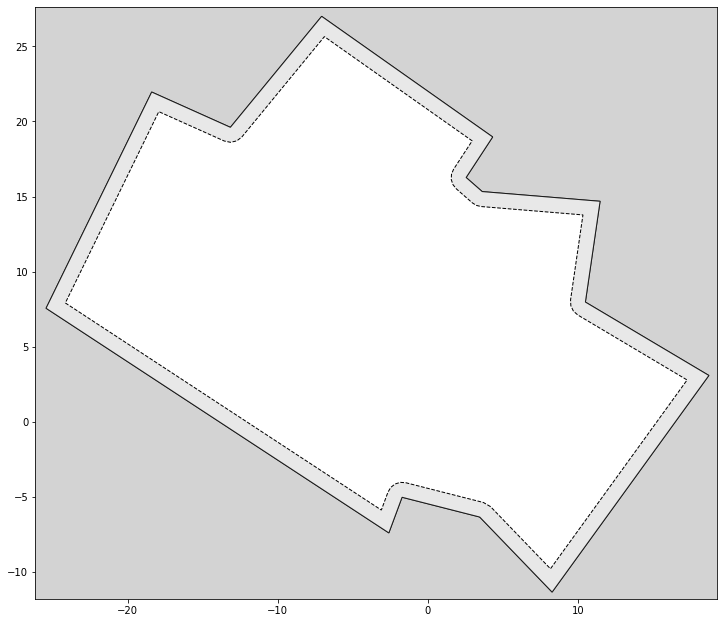

In [58]:
from pcpptc.plot.intermediate import plot_graph

pi = PolygonInstance.from_json(file_path="./01b_instance.json")
ax = setup_plot()
plot_polygon_instance(ax, pi, plot_valuable_areas=False)
plt.show()

In [59]:
figsize = (3.5, 3.5)

In [60]:
from pcpptc.utils import distance
from pcpptc.grid_solver import PointVertex
import typing
from shapely.geometry import Polygon


def _get_polygon_cycles(p: Polygon, inward_step: float) -> typing.Iterable[Polygon]:
    boundary = p.buffer(-0.05, join_style=2, cap_style=2)
    while boundary:
        if type(boundary) is Polygon:
            yield boundary
        else:
            for p in boundary:
                yield p
        offset_boundary = boundary.buffer(
            -inward_step, resolution=4, join_style=2, cap_style=2
        )
        if not offset_boundary:  # not sufficient but will cover more
            offset_boundary = boundary.buffer(
                -0.5 * inward_step, resolution=4, join_style=2, cap_style=2
            )
        boundary = offset_boundary


def _split_boundaries(p: Polygon) -> typing.Iterable[Polygon]:
    yield Polygon(p.exterior.coords)
    for hole in p.interiors:
        yield Polygon(hole.coords)


def _points_on_segment(
    begin: PointVertex, end: PointVertex, max_dist: float
) -> typing.Iterable[PointVertex]:
    dist = distance(begin, end)
    n = round(dist / max_dist)
    yield begin
    if n <= 1:
        return
    step_size = dist / n
    step = step_size * (end.point.to_np() - begin.point.to_np()) / dist
    for i in range(1, n):
        p = begin.point.to_np() + i * step
        yield PointVertex(p[0], p[1])


def _extend_points(
    points: typing.List[PointVertex], max_dist: float
) -> typing.Iterable[PointVertex]:
    for i, p in enumerate(points):
        end = points[(i + 1) % len(points)]
        for pp in _points_on_segment(p, end, max_dist):
            yield pp


def _create_cycle_on_polygon_exterior(
    p: Polygon, max_dist: float
) -> typing.List[PointVertex]:
    points = [PointVertex(coord[0], coord[1]) for coord in p.exterior.coords[:-1]]
    assert len({p.point for p in points}) == len(points), "No duplicates"
    points = list(_extend_points(points, max_dist))
    assert len({p.point for p in points}) == len(points), "No duplicates"
    return points


def compute_offset_cycle_points(
    p: Polygon, tool_radius: float
) -> typing.List[PointVertex]:
    """
    Computes a simple offset cycle cover
    """
    fs = []
    for p in _get_polygon_cycles(p, inward_step=2 * tool_radius):
        p = p.simplify(0.1 * tool_radius, preserve_topology=True)
        for pp in _split_boundaries(p):
            d = get_optimal_grid_edge_length(
                triangular=True, point_based=False, tool_radius=tool_radius
            )
            fs += _create_cycle_on_polygon_exterior(pp, d)
    return fs

In [61]:
feasible_area = pi.original_area.buffer(
    -1.05 * pi.tool_radius, join_style=2, cap_style=2
).simplify(0.1)
points = compute_offset_cycle_points(feasible_area, pi.tool_radius)

PointVertex[140124204470736]@(4.04116850830528, -5.366333174128709)
PointVertex[140124204471376]@(1.8962167723142778, -4.820437706688804)
PointVertex[140124208558416]@(-0.24873496367672487, -4.274542239248899)
PointVertex[140124204470992]@(-2.393686699667727, -3.7286467718089944)
PointVertex[140124204472080]@(-3.138560903706573, -5.737616816162747)
PointVertex[140124205458128]@(-5.0362521591552305, -4.4938495385879555)
PointVertex[140124204471440]@(-6.933943414603888, -3.2500822610131634)
PointVertex[140124208562064]@(-8.831634670052544, -2.0063149834383713)
PointVertex[140124209144464]@(-10.729325925501202, -0.7625477058635797)
PointVertex[140124209144144]@(-12.62701718094986, 0.481219571711212)
PointVertex[140124209144976]@(-14.524708436398516, 1.7249868492860045)
PointVertex[140124209145616]@(-16.422399691847176, 2.968754126860796)
PointVertex[140124203096080]@(-18.32009094729583, 4.212521404435588)
PointVertex[140124203097808]@(-20.217782202744488, 5.4562886820103795)
PointVertex[1

<Figure size 432x288 with 0 Axes>

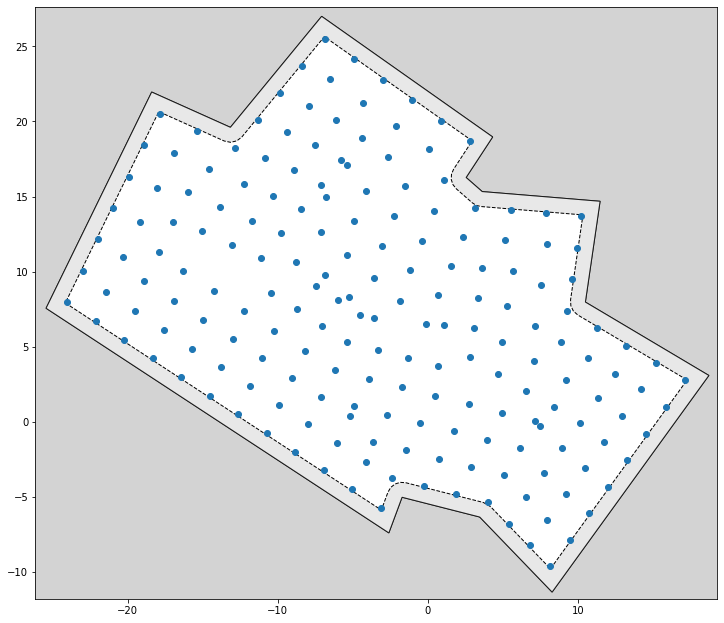

In [62]:
ax = setup_plot()
plot_polygon_instance(ax, pi, plot_valuable_areas=False)
plt.scatter([p.x for p in points], [p.y for p in points], zorder=3)
plt.show()

In [63]:
from shapely.geometry import MultiPoint
from shapely.ops import triangulate

point_map = {(p.x, p.y): (i, p) for i, p in enumerate(points)}
delaunay_points = MultiPoint([p for p in point_map.keys()])
triangles = triangulate(delaunay_points)

In [64]:
# def is_triangle_contained()

cells = []
for triangle in triangles:
    if pi.feasible_area.contains(triangle):
        cell = []
        assert len(triangle.exterior.coords) == 4
        for p in triangle.exterior.coords[:-1]:
            i, p_ = point_map[(p[0], p[1])]
            cell.append(i)
        cells.append(cell)
print(cells)

[[15, 14, 63], [15, 63, 16], [16, 63, 64], [16, 64, 17], [17, 64, 65], [17, 65, 18], [18, 65, 19], [19, 65, 66], [19, 66, 20], [20, 66, 67], [20, 67, 21], [21, 67, 22], [27, 26, 73], [27, 73, 28], [28, 73, 74], [28, 74, 29], [29, 74, 75], [29, 75, 30], [30, 75, 31], [31, 75, 76], [31, 76, 32], [32, 76, 33], [37, 36, 81], [37, 81, 38], [44, 43, 87], [44, 87, 45], [51, 50, 52], [4, 3, 5], [5, 3, 54], [5, 54, 6], [6, 54, 55], [6, 55, 7], [7, 55, 56], [7, 56, 8], [8, 56, 57], [8, 57, 9], [9, 57, 58], [9, 58, 10], [10, 58, 59], [10, 59, 11], [11, 59, 60], [11, 60, 12], [12, 60, 61], [12, 61, 13], [13, 61, 62], [13, 62, 14], [14, 62, 63], [63, 62, 106], [63, 106, 64], [64, 106, 107], [64, 107, 65], [65, 107, 108], [65, 108, 66], [66, 108, 109], [66, 109, 67], [67, 109, 68], [67, 68, 22], [22, 68, 23], [25, 24, 71], [25, 71, 72], [25, 72, 26], [26, 72, 73], [73, 72, 115], [73, 115, 74], [74, 115, 116], [74, 116, 75], [75, 116, 117], [75, 117, 76], [76, 117, 77], [76, 77, 33], [33, 77, 78], [3

In [65]:
import optimesh
import numpy as np

point_data = np.array([[p.x, p.y] for p in points])
points_, cells_ = optimesh.optimize_points_cells(
    point_data, cells, "CVT (block-diagonal)", 1.0e-5, 1000
)

<Figure size 432x288 with 0 Axes>

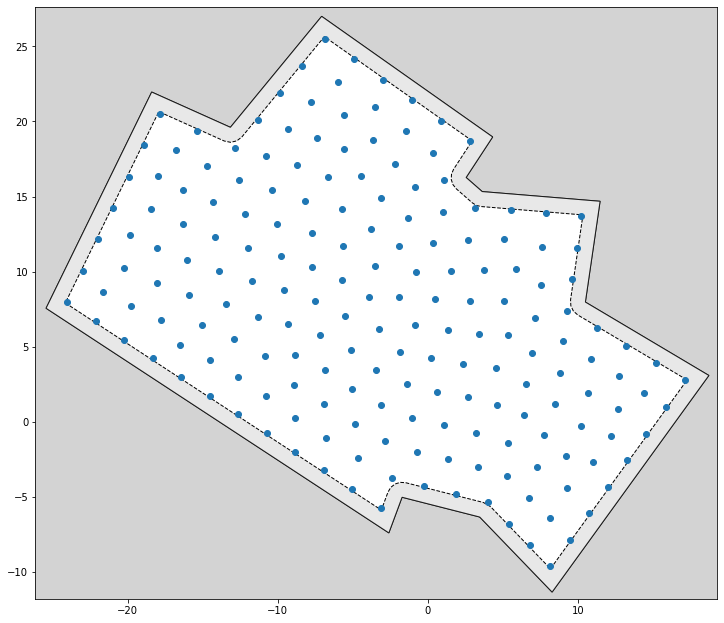

In [66]:
ax = setup_plot()
plot_polygon_instance(ax, pi, plot_valuable_areas=False)
plt.scatter([p[0] for p in points_], [p[1] for p in points_], zorder=3)
plt.show()